In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np


CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:1'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 491.95it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8142.38it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [7]:
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)

In [2]:
def get_epoch_plot_measures(epoch):
        """get plot measure for visualization"""
        # data = self.train_representation
        data = ref_provider.train_representation(epoch)
        embedded = projector.batch_project(epoch, data)

        ebd_min = np.min(embedded, axis=0)
        ebd_max = np.max(embedded, axis=0)
        ebd_extent = ebd_max - ebd_min

        x_min, y_min = ebd_min - 0.1 * ebd_extent
        x_max, y_max = ebd_max + 0.1 * ebd_extent

        x_min = min(x_min, y_min)
        y_min = min(x_min, y_min)
        x_max = max(x_max, y_max)
        y_max = max(x_max, y_max)

        return x_min, y_min, x_max, y_max


In [3]:
x_min, y_min, x_max, y_max = get_epoch_plot_measures(200)
resolution = 200
# create grid
xs = np.linspace(x_min, x_max, resolution)
ys = np.linspace(y_min, y_max, resolution)
grid = np.array(np.meshgrid(xs, ys))
grid = np.swapaxes(grid.reshape(grid.shape[0], -1), 0, 1)

In [4]:
# map gridmpoint to images
grid_samples = projector.batch_inverse(200, grid)
#### in ref ' space
np_grid_samples = np.asarray(grid_samples)

In [5]:
tar_projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
# map gridmpoint to images
tar_grid_samples = tar_projector.batch_inverse(200, grid)
tar_np_grid_samples = np.asarray(grid_samples)

In [12]:
autoencoder = SimpleAutoencoder(input_dim,output_dim)
########### load pre autoencoder

batch_size = 100
######### train sample + generated boundary sample's => input  #############
from AlignVisAutoEncoder.data_loader import DataLoaderInit

indicates = np.random.choice(np.arange(90000), size=10000, replace=False)

# input_X = torch.Tensor(np_grid_samples)
# input_Y = torch.Tensor(tar_np_grid_samples)
input_X = np.concatenate((ref_provider.train_representation(REF_EPOCH), np_grid_samples),axis=0)
input_Y = np.concatenate((tar_provider.train_representation(TAR_EPOCH), tar_np_grid_samples),axis=0)
data_loader_b = DataLoaderInit(input_X[indicates], input_Y[indicates], batch_size)
dataloader_b = data_loader_b.get_data_loader()

In [11]:
input_X.shape

(90000, 512)

In [15]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss





def kl_div_loss(P, Q):
    # Check if the input contains NaN, infinity, or very large values
    if not torch.isfinite(P).all() or not torch.isfinite(Q).all() or not torch.max(torch.abs(P)).item() < np.finfo(np.float32).max or not torch.max(torch.abs(Q)).item() < np.finfo(np.float32).max:
        # Replace NaN, infinity, or very large values with zeros
        P[~torch.isfinite(P) | (torch.abs(P) >= np.finfo(np.float32).max)] = 0
        Q[~torch.isfinite(Q) | (torch.abs(Q) >= np.finfo(np.float32).max)] = 0

    kl_divergence = torch.sum(P * torch.log(P / Q))

    # Calculate KL divergence between Q and P
    kl_divergence += torch.sum(Q * torch.log(Q / P))

    # Return the average KL divergence
    return kl_divergence.mean()

def gaussian_kernel(x1, x2, sigma=1.0):
    x1 = x1.unsqueeze(1)  # shape: (n1, 1, d)
    x2 = x2.unsqueeze(0)  # shape: (1, n2, d)
    dist = torch.sum((x1 - x2) ** 2, dim=-1)  # shape: (n1, n2)
    return torch.exp(-dist / (2 * sigma ** 2))

def mmd_loss(x1, x2, kernel=gaussian_kernel, sigma=1.0):
    n1, n2 = x1.size(0), x2.size(0)

    k11 = kernel(x1, x1, sigma=sigma).sum() / (n1 * (n1 - 1))
    k22 = kernel(x2, x2, sigma=sigma).sum() / (n2 * (n2 - 1))
    k12 = kernel(x1, x2, sigma=sigma).sum() / (n1 * n2)

    return k11 + k22 - 2 * k12



def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    loss = emd(first_histogram, second_histogram, distance_matrix)
    loss_tensor = torch.tensor(loss, requires_grad=True)

    return loss_tensor

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())

    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 200
learning_rate = 1e-4

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements


checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/cak_1v1.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

input_X = np_grid_samples
input_Y = tar_grid_samples
data_loader_b = DataLoaderInit(input_X, input_Y, batch_size)
dataloader_b = data_loader_b.get_data_loader()

# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader_b: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        ##### knn loss
        knn_overlap_loss = KNNOverlapLoss(k=15)
        knn_loss_encoder = knn_overlap_loss(input=transformed_Y, target=data_Y)

        knn_loss_decoder = knn_overlap_loss(input=recon_X, target=data_Y)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_X) +  knn_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + knn_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)

        mmd_loss_v = mmd_loss(recon_X,data_Y)

        #### CKA loss
        cka_loss_f = CKALoss(gamma=None, alpha=1e-8)
        cka_loss = cka_loss_f(data_Y,transformed_Y,recon_X)

        loss = loss_f_decoder + loss_f_encoder + 0.01 * pred_loss + cka_loss + mmd_loss_v

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss.item():.4f},CKA,{cka_loss.item():.4f},mmd_loss:{mmd_loss_v}')

torch.save({
    'epoch': TAR_EPOCH,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/drop_only_boundary.pth")


100%|██████████| 1/1 [00:00<00:00, 3728.27it/s]


Epoch [1/10], Loss: 0.3949, Loss decoder: 0.1044,Loss encoder: 0.0381,pred_loss,24.1501,CKA,0.0006,mmd_loss:0.010299930348992348


100%|██████████| 1/1 [00:00<00:00, 3310.42it/s]


Epoch [2/10], Loss: 0.3371, Loss decoder: 0.1003,Loss encoder: 0.0307,pred_loss,19.5573,CKA,0.0003,mmd_loss:0.010136628523468971


100%|██████████| 1/1 [00:00<00:00, 3048.19it/s]


Epoch [3/10], Loss: 0.3073, Loss decoder: 0.1055,Loss encoder: 0.0419,pred_loss,14.9239,CKA,0.0004,mmd_loss:0.010188845917582512


100%|██████████| 1/1 [00:00<00:00, 4634.59it/s]


Epoch [4/10], Loss: 0.2941, Loss decoder: 0.0928,Loss encoder: 0.0351,pred_loss,15.5727,CKA,0.0002,mmd_loss:0.01029528770595789


100%|██████████| 1/1 [00:00<00:00, 4609.13it/s]


Epoch [5/10], Loss: 0.3305, Loss decoder: 0.0861,Loss encoder: 0.0359,pred_loss,19.8070,CKA,0.0003,mmd_loss:0.010136191733181477


100%|██████████| 1/1 [00:00<00:00, 3578.76it/s]


Epoch [6/10], Loss: 0.2598, Loss decoder: 0.0799,Loss encoder: 0.0324,pred_loss,13.7236,CKA,0.0001,mmd_loss:0.010166137479245663


100%|██████████| 1/1 [00:00<00:00, 2671.53it/s]


Epoch [7/10], Loss: 0.2613, Loss decoder: 0.0885,Loss encoder: 0.0311,pred_loss,13.1280,CKA,0.0002,mmd_loss:0.010173527523875237


100%|██████████| 1/1 [00:00<00:00, 3715.06it/s]


Epoch [8/10], Loss: 0.2397, Loss decoder: 0.0817,Loss encoder: 0.0289,pred_loss,11.8709,CKA,0.0002,mmd_loss:0.010226945392787457


100%|██████████| 1/1 [00:00<00:00, 4963.67it/s]


Epoch [9/10], Loss: 0.2417, Loss decoder: 0.0834,Loss encoder: 0.0339,pred_loss,11.3853,CKA,0.0002,mmd_loss:0.010332044214010239


100%|██████████| 1/1 [00:00<00:00, 3385.23it/s]

Epoch [10/10], Loss: 0.2879, Loss decoder: 0.0863,Loss encoder: 0.0350,pred_loss,15.6280,CKA,0.0001,mmd_loss:0.010185964405536652


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7616.76it/s]


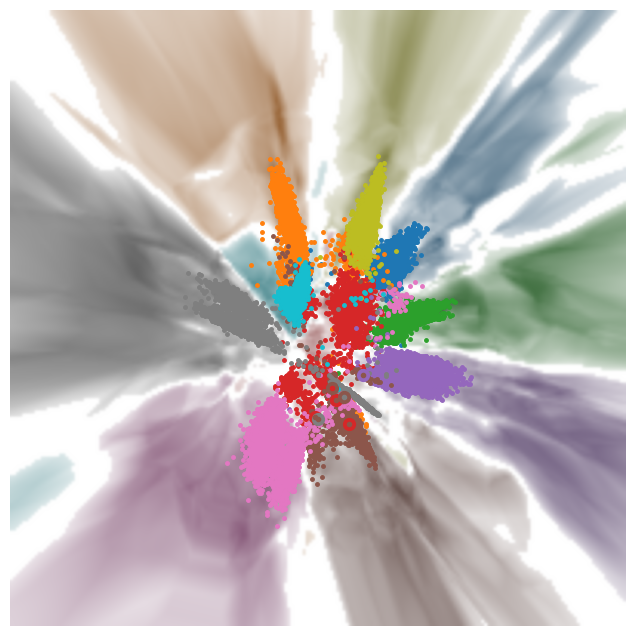

In [18]:

##### visuallize all data
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/cak_1v1.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVisAutoEncoder.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

ref_projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

x_min, y_min, x_max, y_max = get_epoch_plot_measures(200,ref_provider, ref_projector )
resolution = 200
# # create grid
xs = np.linspace(x_min, x_max, resolution)
ys = np.linspace(y_min, y_max, resolution)
grid = np.array(np.meshgrid(xs, ys))
grid = np.swapaxes(grid.reshape(grid.shape[0], -1), 0, 1)
# map gridmpoint to images
tar_grid_samples = projector.batch_inverse(200, grid)

# #### in ref ' space
# np_grid_samples = np.asarray(grid_samples)

I = np.eye(512)

from AlignVisAutoEncoder.visualizer_grids import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, autoencoder, np.dot(tar_grid_samples,I), projector, 200,[], False,'tab10')
# from representationTrans.visualizer import visualizer
# vis = visualizer(tar_provider, I,I, np.dot(tar_provider.test_representation(200), I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [19]:
from AlignVis_eval.Alignmenteval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)

In [23]:
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/drop_boundary.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
eval.eval_nn_train_autoencoder(15, autoencoder)

Fri Apr 21 18:11:26 2023 Building RP forest with 16 trees
Fri Apr 21 18:11:27 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Apr 21 18:11:28 2023 Building RP forest with 16 trees
Fri Apr 21 18:11:28 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.35/15 in epoch 200


1.34806

In [26]:
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/dropout_for_b_epoch_200.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
eval.eval_nn_train_autoencoder(15, autoencoder)

Fri Apr 21 18:12:57 2023 Building RP forest with 16 trees
Fri Apr 21 18:12:58 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Apr 21 18:12:59 2023 Building RP forest with 16 trees
Fri Apr 21 18:12:59 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.37/15 in epoch 200


1.37096

In [22]:
eval.eval_nn_train_ref_in_ref(15)

Fri Apr 21 18:10:43 2023 Building RP forest with 16 trees
Fri Apr 21 18:10:44 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Apr 21 18:10:45 2023 Building RP forest with 16 trees
Fri Apr 21 18:10:45 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving ref in ref: 1.22/15 in epoch 200


1.22082